In [1]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DiffusionModel(nn.Module):
    def __init__(self, data_size=100, time_embedding_size=20, hidden_size=256):
        super(DiffusionModel, self).__init__()
        self.time_embedding = nn.Linear(1, time_embedding_size)
        self.hidden_size = hidden_size
        self.network = nn.Sequential(
            nn.Linear(data_size + time_embedding_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, data_size)
        )

    def forward(self, x, t):
        # Ensure t is a 2D tensor with shape [batch_size, 1]
        t = t.unsqueeze(-1) if t.dim() == 1 else t
        
        # Embedding the time step
        t_emb = self.time_embedding(t)

        # Concatenating the time embedding to the input
        xt = torch.cat([x, t_emb], dim=1)
        
        return self.network(xt)


In [2]:
import torch.nn.functional as F

def train_diffusion_model(model, data_loader, optimizer, num_epochs, num_steps, device):
    model.train()
    
    # Example linear noise schedule (beta values)
    betas = torch.linspace(0.0001, 0.02, num_steps).to(device)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    for epoch in range(num_epochs):
        for batch in data_loader:
            data = batch[0].to(device)
            
            for step in range(1, num_steps + 1):
                # Sample time step
                t = torch.randint(0, num_steps, (data.size(0),), device=device)
                t_float = t.float() / (num_steps - 1)
                
                # Calculate noise for this step
                noise = torch.randn_like(data)
                
                # Calculate the noisy data based on the noise schedule
                sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod[t]).unsqueeze(-1)
                sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod[t]).unsqueeze(-1)
                noisy_data = sqrt_alphas_cumprod * data + sqrt_one_minus_alphas_cumprod * noise
                
                optimizer.zero_grad()
                
                # Model prediction (reverse process)
                predicted_noise = model(noisy_data, t_float)
                
                # Calculate loss as MSE between the predicted and actual noise
                loss = F.mse_loss(predicted_noise, noise)
                
                loss.backward()
                optimizer.step()
                
        print(f"Epoch: {epoch}, Loss: {loss.item()}")


In [3]:
def generate_samples(model, num_samples, data_size, num_steps, device='cpu'):
    model.eval()  # Ensure the model is in evaluation mode.

    # Initial random noise
    x_t = torch.randn(num_samples, data_size).to(device)

    # Linear noise schedule used during training
    betas = torch.linspace(0.0001, 0.02, num_steps).to(device)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    # Generate t values for reverse process, normalized
    t_values = torch.arange(0, num_steps).flip(0).to(device)

    with torch.no_grad():
        for t in t_values:
            # Calculate the current alpha and noise for this step
            sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod[t])
            sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod[t])
            t_norm = t.float() / (num_steps - 1)
            t_batch = t_norm.repeat(num_samples, 1)
            # Prepare t for model input (ensure it's the correct shape and type)

            # Model prediction to refine the current state
            epsilon_t = model(x_t, t_batch)
            mu_t = (x_t - (1 - alphas[t]) / sqrt_one_minus_alphas_cumprod * epsilon_t) / torch.sqrt(alphas[t])
            noise1 = torch.randn(num_samples, data_size).to(device)
            x_t = mu_t + torch.sqrt(betas[t]) * noise1

    return x_t


In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Load and scale data
data = np.load("../data/eb_subset_all.npz")
all_data = torch.tensor(data['phate'], dtype=torch.float32)
mean_val = torch.mean(all_data)
std_val = torch.std(all_data)
# Standardize data
scaled_data = (all_data - mean_val) / std_val

# Split into training and validation sets
train_data, val_data = train_test_split(scaled_data, test_size=0.2, random_state=42)

# Convert to tensor datasets
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)

# Create DataLoaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [5]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Model and optimizer
model = DiffusionModel(
    data_size=2,  # Assuming the data has shape [batch_size, data_size]
    time_embedding_size=8,
    hidden_size=64
).to(device)  # Assuming 'device' is defined, e.g., 'cpu' or 'cuda'
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
train_diffusion_model(model, train_loader, optimizer, num_epochs=10, num_steps=1000, device=device)

Epoch: 0, Loss: 0.17611666023731232
Epoch: 1, Loss: 0.18114624917507172
Epoch: 2, Loss: 0.2131246030330658
Epoch: 3, Loss: 0.18764738738536835
Epoch: 4, Loss: 0.2034936398267746
Epoch: 5, Loss: 0.199528306722641
Epoch: 6, Loss: 0.1879376918077469
Epoch: 7, Loss: 0.19646203517913818
Epoch: 8, Loss: 0.22229349613189697
Epoch: 9, Loss: 0.1974681168794632


In [6]:
gs = generate_samples(model, num_samples=3000, data_size=2, num_steps=1000, device=device)

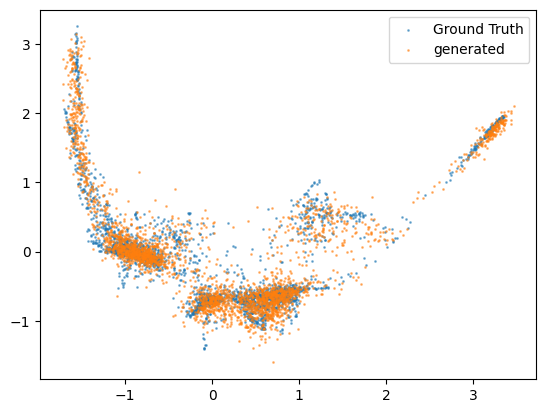

In [7]:
import matplotlib.pyplot as plt
gt = scaled_data.cpu().numpy()
plt.scatter(gt[:,0], gt[:,1], label='Ground Truth', s=1, alpha=0.5)
plt.scatter(gs[:, 0].cpu().numpy(), gs[:, 1].cpu().numpy(), s=1, label='generated', alpha=0.5)
plt.legend()

In [8]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot

In [9]:
gt = scaled_data.to(device)

In [10]:
M = ot.dist(gs, gt)

In [11]:
# M = M/M.max()

In [12]:
xs = gs.cpu().numpy()
xt = gt.cpu().numpy()

Text(0.5, 1.0, 'Cost matrix M')

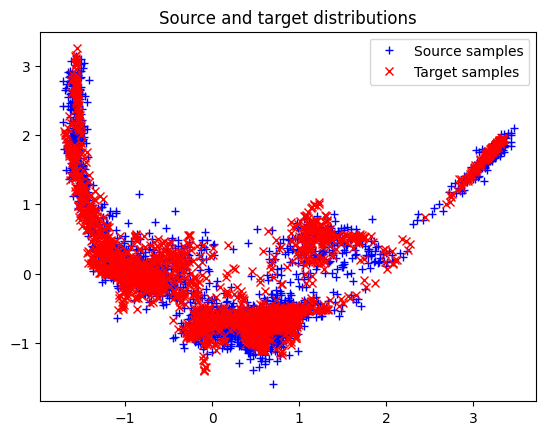

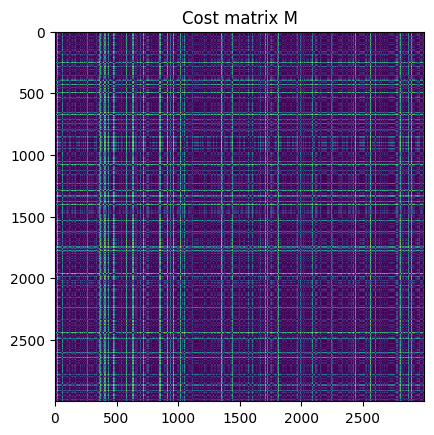

In [13]:
pl.figure(1)
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('Source and target distributions')

pl.figure(2)
pl.imshow(M.cpu().numpy(), interpolation='nearest')
pl.title('Cost matrix M')

Text(0.5, 1.0, 'OT matrix with samples')

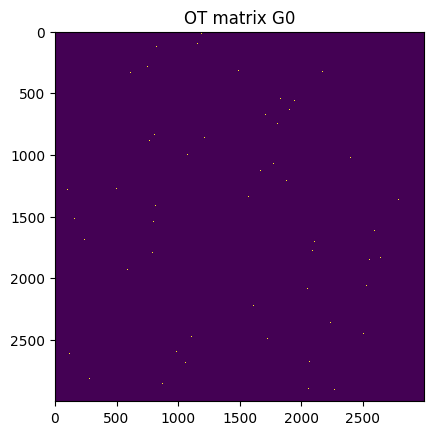

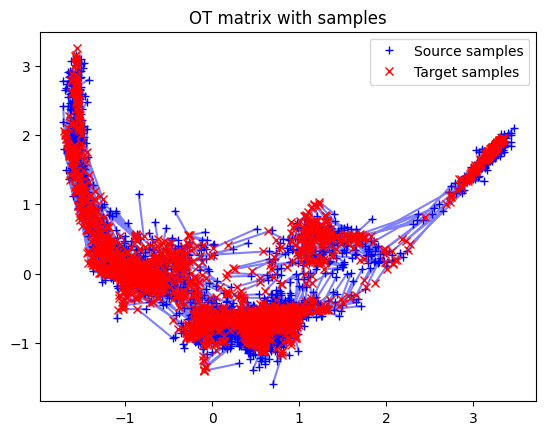

In [14]:
n = gs.size(0)
a, b = torch.ones((n,)).to(device) / n, torch.ones((n,)).to(device) / n  # uniform distribution on samples

G0 = ot.emd(a, b, M)

pl.figure(3)
pl.imshow(G0.cpu().numpy(), interpolation='nearest')
pl.title('OT matrix G0')

pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, G0.cpu().numpy(), c=[.5, .5, 1])
pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

In [15]:
G0.shape

torch.Size([3000, 3000])

In [16]:
W = torch.sum(G0 * M)

In [17]:
W

tensor(0.0411, device='cuda:0')

Sinkhorn crashes.

In [18]:
# lambd = 1e-1
# Gs = ot.sinkhorn(a, b, M, lambd)

# pl.figure(5)
# pl.imshow(Gs.cpu().numpy(), interpolation='nearest')
# pl.title('OT matrix sinkhorn')

# pl.figure(6)
# ot.plot.plot2D_samples_mat(xs, xt, Gs.cpu().numpy(), color=[.5, .5, 1])
# pl.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
# pl.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
# pl.legend(loc=0)
# pl.title('OT matrix Sinkhorn with samples')

# pl.show()